In [1]:
# -*- coding: utf-8 -*-
#
#  Copyright 2024 Technical University of Denmark
#  Authored by: Piotr Budzisz (DTU)
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#
#  Note: The following code has been created for the purpose of a master's thesis by Piotr Budzisz titled
#  "Computational reduction of reconstruction artifacts in stitching-based biomedical computed tomography,"
#  written at the Technical University of Denmark. The file is based on and reuses parts and descriptions
#  from the Core Imaging Library notebooks created by :
#
#                   Jakob S. Jørgensen (DTU)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#
#  which can be found in the GitHub repository (https://github.com/TomographicImaging/CIL-Demos).
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 Technical University of Denmark
#
#  The dataset and files mentioned belong to the CFU (Center for Fast Ultrasound Imaging) at DTU (Technical University of Denmark).

# First reconstruction in CIL using FBP. Slice Z2.35 X-1.17 Y1.83. 




In [2]:
# Import all CIL components needed
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

# CIL Processors
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter, Normaliser, Padder

# CIL display tools
from cil.utilities.display import show2D, show_geometry

# CIL FBP
from cil.recon import FBP

# From CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# All external imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

In [3]:
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

In [27]:
#load slice 1023 from a .mat file
datapath = "/dtu/cfu/data/userdata18/s220464/storage/KIDNEY_DATA/"
filename = "slice5_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)

In [28]:
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))
ig = ag.get_ImageGeometry()

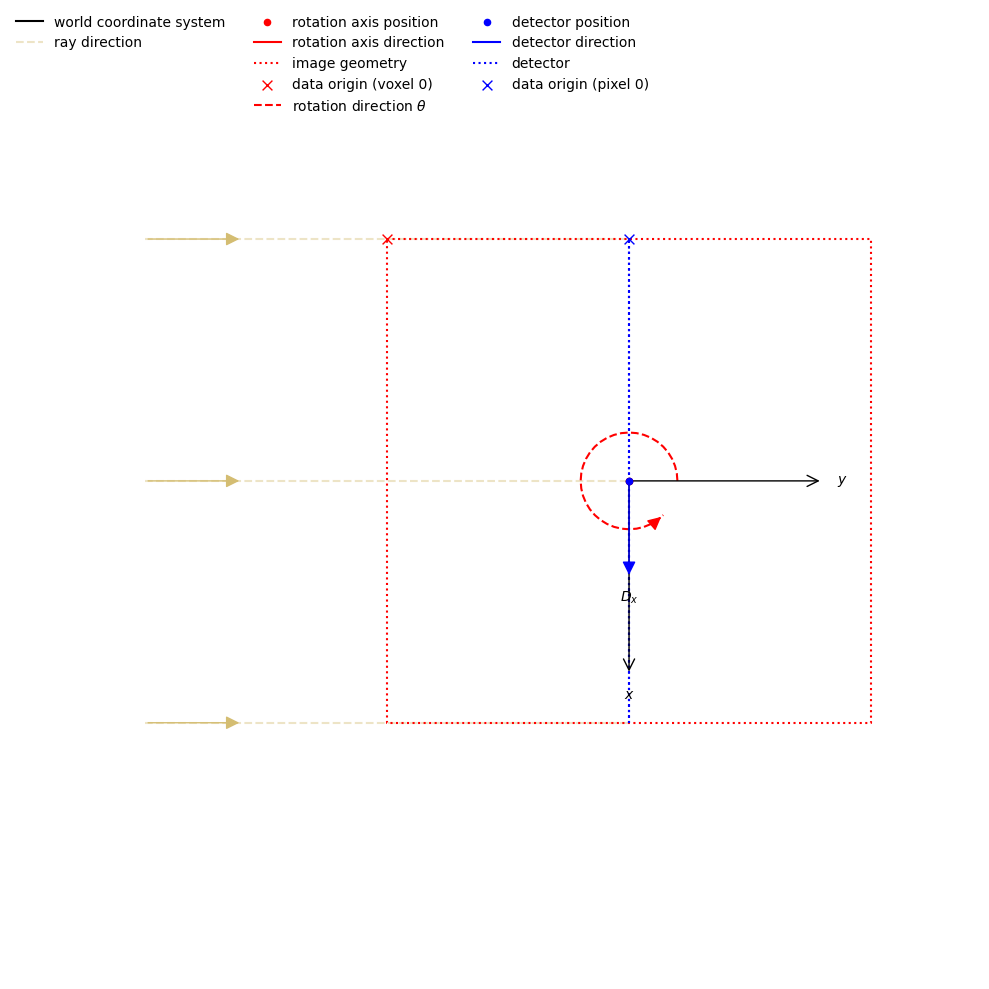

In [29]:
show_geometry(ag, ig)

In [30]:
ag.set_labels(['horizontal','angle'])

In [31]:
data = AcquisitionData(projs, geometry=ag, deep_copy=False)

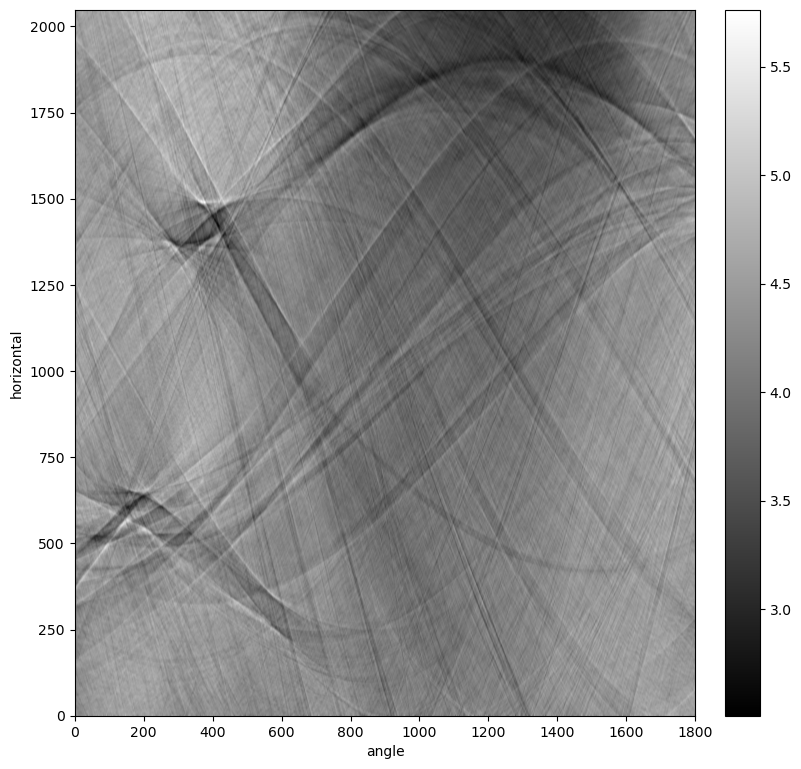

In [32]:
show2D(data)

In [33]:
data.reorder('astra')

In [34]:
rec_1 = FBP(data, ig, backend='astra').run()

FBP recon

Input Data:
	angle: 1800
	horizontal: 2048

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



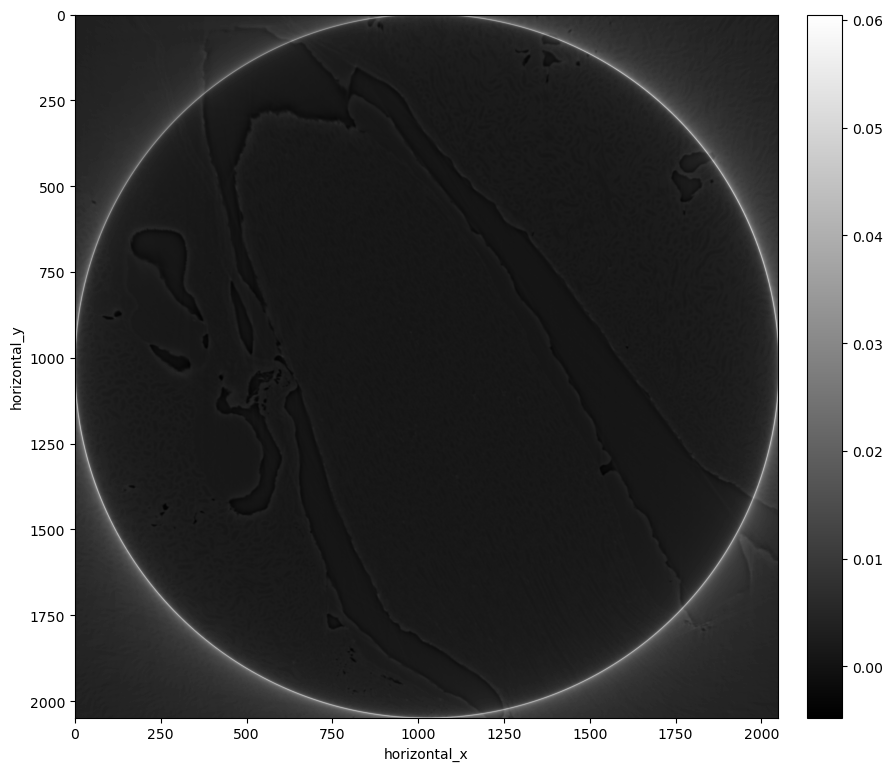

In [35]:
show2D(rec_1, cmap='gray', num_cols=1, size=(15,15), origin='upper-left')

In [36]:
padsize = 512
data_pad_512 = Padder.edge(pad_width={'horizontal': padsize})(data)

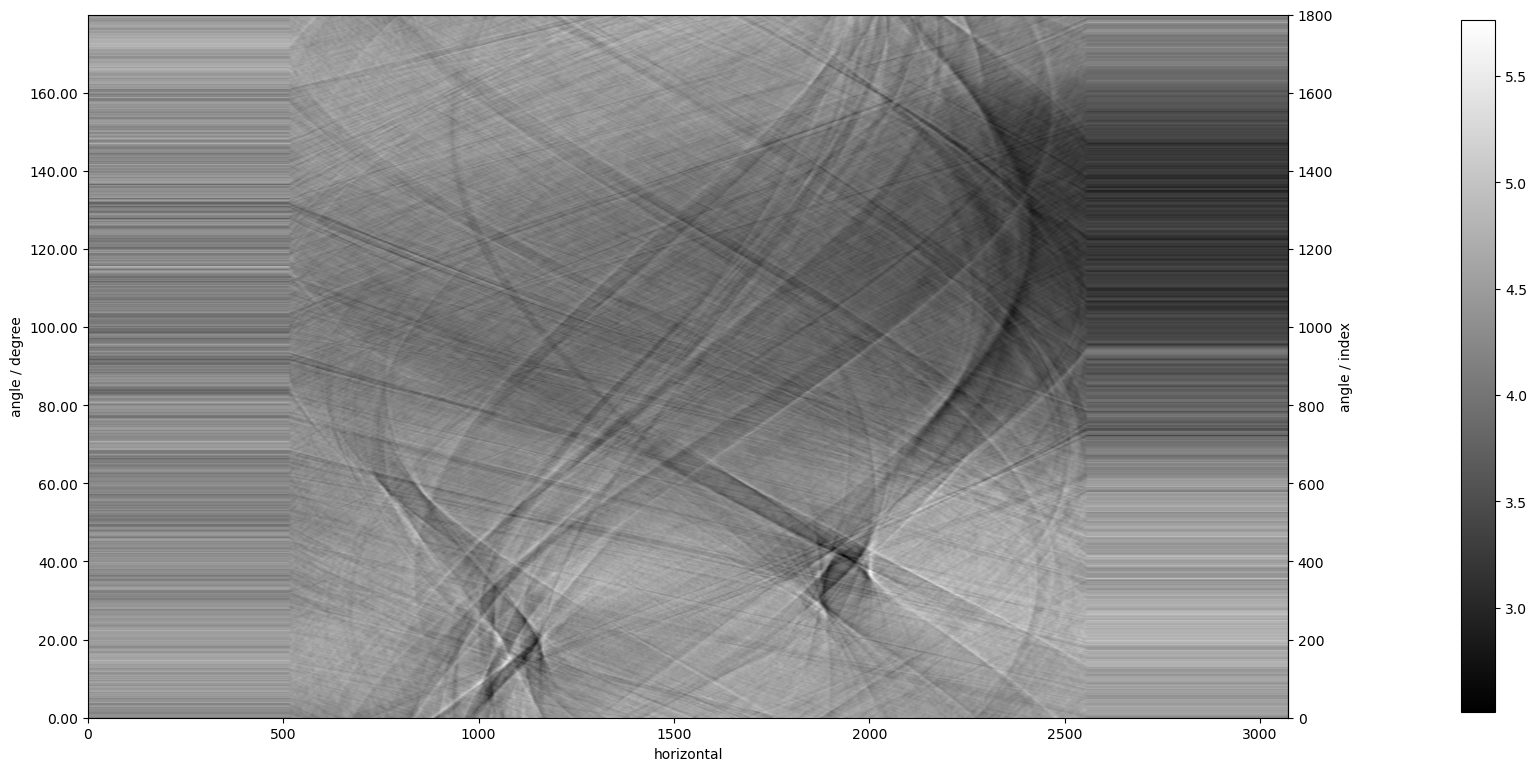

(1800, 2048)

In [37]:
show2D(data_pad_512)
data.shape

We see the data has been extended left and right. In effect the sinogram is now larger, so we need to create a new FBP reconstructor configured for the new padded data. We keep the reconstruction volume (defined by our image geometry) the same as before as we are not interested in the extended region.

In [38]:
rec_2 = FBP(data_pad_512, ig, backend='astra').run()

FBP recon

Input Data:
	angle: 1800
	horizontal: 3072

Reconstruction Volume:
	horizontal_y: 2048
	horizontal_x: 2048

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



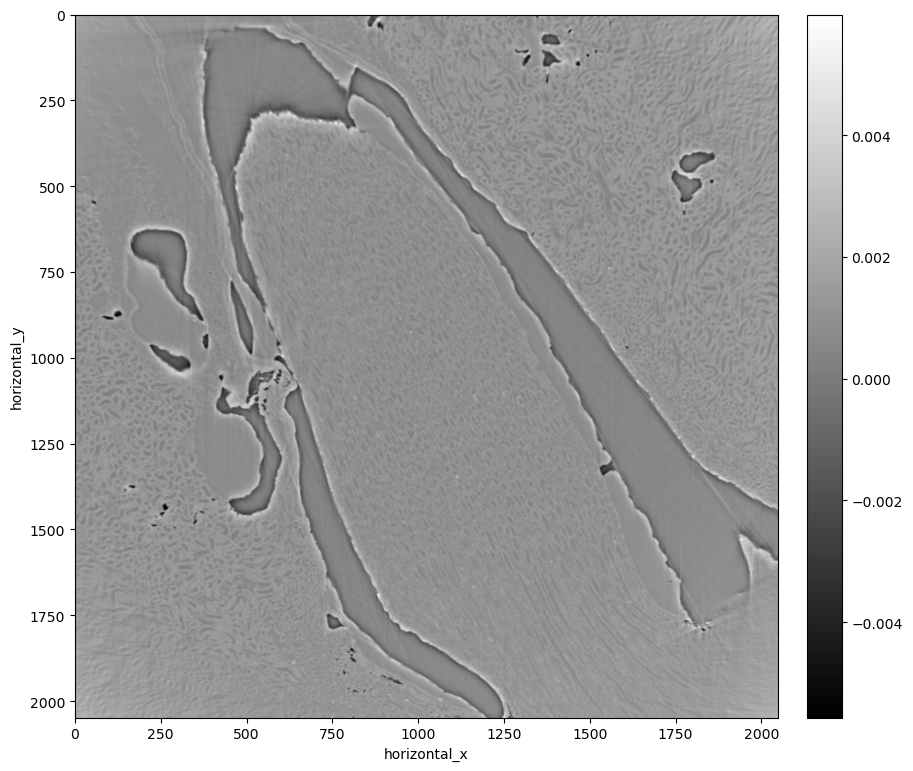

In [39]:
show2D(rec_2, cmap='gray', num_cols=1, size=(15,15), origin='upper-left')

In [40]:
# apply circle mask 
from numpy import arange, meshgrid, isscalar, ndarray, pi, roll
offset = 0

siz = 2048
if siz % 2:
    rang = arange(-siz / 2 + 1, siz / 2 + 1)
else:
    rang = arange(-siz / 2,siz / 2)
x,y = meshgrid(rang,rang)
z = x ** 2 + y ** 2
a = (z < (siz / 2 - abs(offset)) ** 2)
rec_3 = rec_2 * a	

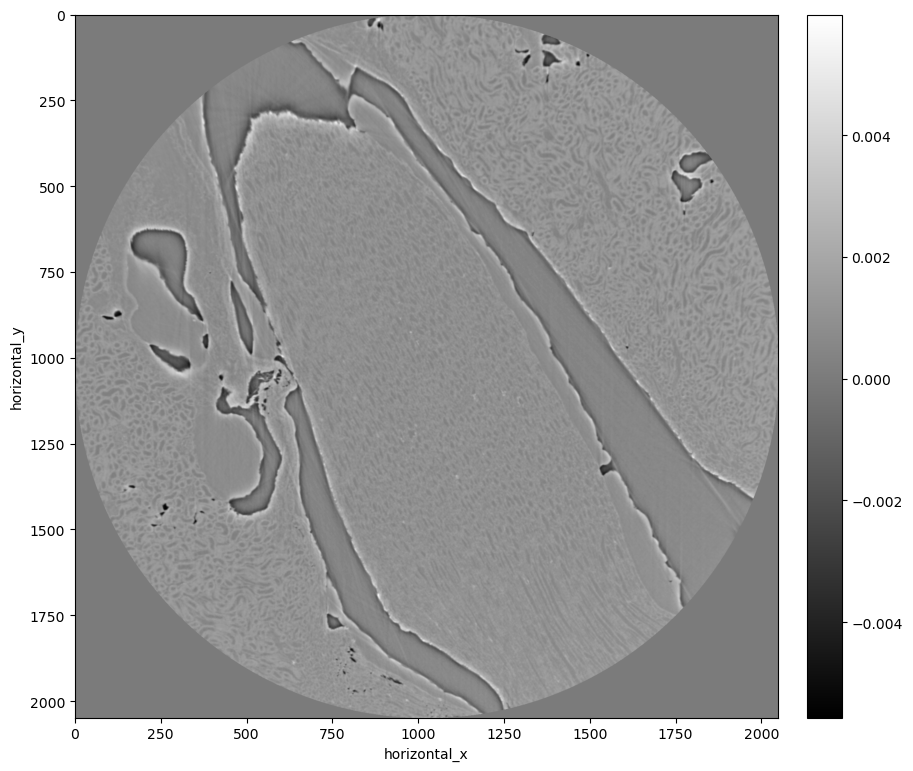

In [42]:
show2D(rec_3, cmap='gray', num_cols=1, size=(15,15), origin='upper-left')

In [ ]:
from cil.io import TIFFWriter
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/PHASE_1'
save_path = os.path.join(save_base_path, 'recon.tiff')
TIFFWriter(data=rec_3, file_name=save_path).write()